# Explaining Tree Models with Path-Dependent Feature Perturbation Tree SHAP

<div class="alert alert-info">
Note
    
To enable SHAP support, you may need to run
    
```bash
pip install alibi[shap]
```

</div>

In [ ]:
# shap.summary_plot currently doesn't work with matplotlib>=3.6.0,
# see bug report: https://github.com/slundberg/shap/issues/2687
!pip install matplotlib==3.5.3

## Introduction

This example shows how to apply path-dependent feature perturbation Tree SHAP to compute shap values exactly for an `xgboost` model fitted to the `Adult` dataset (binary classification task). An example of how to decompose the contribution of any given feature into a main effect and interactions with other features is also presented.

This example will use the [xgboost](https://github.com/dmlc/xgboost) library, which can be installed with:

In [ ]:
!pip install xgboost

In [1]:
import pickle
import shap
shap.initjs()

import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from alibi.datasets import fetch_adult
from alibi.explainers import TreeShap
from functools import partial
from itertools import product, zip_longest
from scipy.special import expit
invlogit=expit
from sklearn.metrics import accuracy_score, confusion_matrix

from timeit import default_timer as timer

## Data preparation

### Load and split

The `fetch_adult` function returns a `Bunch` object containing the features, targets, feature names and a mapping of categorical variables to numbers.

In [2]:
adult = fetch_adult()
adult.keys()

dict_keys(['data', 'target', 'feature_names', 'target_names', 'category_map'])

In [3]:
data = adult.data
target = adult.target
target_names = adult.target_names
feature_names = adult.feature_names
category_map = adult.category_map

Note that for your own datasets you can use the utility function `gen_category_map` imported from `alibi.utils`  to create the category map.

In [4]:
np.random.seed(0)
data_perm = np.random.permutation(np.c_[data, target])
data = data_perm[:,:-1]
target = data_perm[:,-1]

In [5]:
idx = 30000
X_train,y_train = data[:idx,:], target[:idx]
X_test, y_test = data[idx+1:,:], target[idx+1:]

`xgboost` wraps arrays using  `DMatrix` objects, optimised for both memory efficiency and training speed.

In [6]:
def wrap(arr):
    return np.ascontiguousarray(arr)

dtrain = xgb.DMatrix(
    wrap(X_train), 
    label=wrap(y_train), 
    feature_names=feature_names, 
)

dtest = xgb.DMatrix(wrap(X_test), label=wrap(y_test), feature_names=feature_names)

Finally, a matrix that contains the raw string values for categorical variables (used for display) is created:

In [7]:
def _decode_data(X, feature_names, category_map):
    """
    Given an encoded data matrix `X` returns a matrix where the 
    categorical levels have been replaced by human readable categories.
    """
    
    X_new = np.zeros(X.shape, dtype=object)
    for idx, name in enumerate(feature_names):
        categories = category_map.get(idx, None)
        if categories:
            for j, category in enumerate(categories):
                encoded_vals = X[:, idx] == j
                X_new[encoded_vals, idx] = category
        else:
            X_new[:, idx] = X[:, idx]
        
    return X_new
            
decode_data = partial(_decode_data, feature_names=feature_names, category_map=category_map)

In [8]:
X_display = decode_data(X_test)

In [9]:
X_display

array([[52, 'Private', 'Associates', ..., 0, 60, 'United-States'],
       [21, 'Private', 'High School grad', ..., 0, 20, 'United-States'],
       [43, 'Private', 'Dropout', ..., 0, 50, 'United-States'],
       ...,
       [23, 'Private', 'High School grad', ..., 0, 40, 'United-States'],
       [45, 'Local-gov', 'Doctorate', ..., 0, 45, 'United-States'],
       [25, 'Private', 'High School grad', ..., 0, 48, 'United-States']],
      dtype=object)

## Model definition

The model fitted in the `xgboost` fitting [example](xgboost_model_fitting_adult.ipynb) will be explained. The confusion matrix of this model is shown below:

In [10]:
def plot_conf_matrix(y_test, y_pred, class_names):
    """
    Plots confusion matrix. Taken from:
    http://queirozf.com/entries/visualizing-machine-learning-models-examples-with-scikit-learn-and-matplotlib
    """
    
    matrix = confusion_matrix(y_test,y_pred)


    # place labels at the top
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')

    # plot the matrix per se
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

    # plot colorbar to the right
    plt.colorbar()

    fmt = 'd'

    # write the number of predictions in each bucket
    thresh = matrix.max() / 2.
    for i, j in product(range(matrix.shape[0]), range(matrix.shape[1])):

        # if background is dark, use a white number, and vice-versa
        plt.text(j, i, format(matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if matrix[i, j] > thresh else "black")

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label',size=14)
    plt.xlabel('Predicted label',size=14)
    plt.show()

def predict(xgb_model, dataset, proba=False, threshold=0.5):
    """
    Predicts labels given a xgboost model that outputs raw logits. 
    """
    
    y_pred = model.predict(dataset)  # raw logits are predicted
    y_pred_proba = invlogit(y_pred) 
    if proba:
        return y_pred_proba
    y_pred_class = np.zeros_like(y_pred)
    y_pred_class[y_pred_proba >= threshold] = 1  # assign a label 
    
    return y_pred_class

In [11]:
model = xgb.Booster()  
model.load_model('assets/adult_xgb.mdl')

In [12]:
y_pred_train = predict(model, dtrain)
y_pred_test = predict(model, dtest)

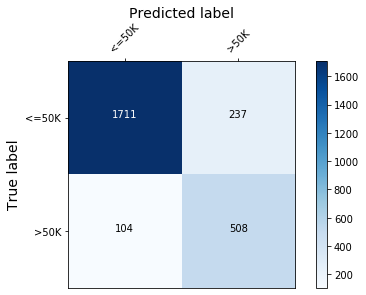

In [13]:
plot_conf_matrix(y_test, y_pred_test, target_names)

Figure 1: Model confusion matrix

In [14]:
print(f'Train accuracy:  {round(100*accuracy_score(y_train, y_pred_train), 4)}  %.')
print(f'Test  accuracy:  {round(100*accuracy_score(y_test, y_pred_test), 4)}%.')

Train accuracy:  87.75  %.
Test  accuracy:  86.6797%.


## Explaining xgboost via global feature importance
<a id='xgboost_importance'></a>

Locally, one could interpret an outcome predicted by a decision tree by analysing the path followed by the sample through the tree (known as the *decision path*). However, for `xgboost` the final decision depends on the number of boosting rounds so this technique is not practical. Moreover, this approach only informs one about _which features_ factored in the decision of the algorithm but nothing about the relative importance of the features. Such a view can only be obtained at a global level, for example, by combining information from decision paths of all ensemble members. The `xgboost` library offers the following measures of feature importance for a feature:

* `weight` - the number of times a feature is used to split the data across all trees

* `gain` - the average gain (that is, contribution to the model output) across all splits the feature is used in

* `cover`<sup>[(1)](#Footnotes) </sup> - the average coverage across all splits the feature is used in

* `total_gain` - the total gain across all splits the feature is used in

* `total_cover` - the total coverage across all splits the feature is used in.

Therefore, one is first faced with the task of choosing _a notion of feature importance_ before interpreting their model. As shown below, different notions of feature importance lead to different explanations for the same model.

<a id='f_2'></a>

In [15]:
def _get_importance(model, measure='weight'):
    """
    Retrieves the feature importances from an xgboost
    models, measured according to the criterion `measure`.
    """
    
    imps = model.get_score(importance_type=measure)
    names, vals = list(imps.keys()), list(imps.values())
    sorter = np.argsort(vals)
    s_names, s_vals = tuple(zip(*[(names[i], vals[i]) for i in sorter]))
    
    return s_vals[::-1], s_names[::-1]

def plot_importance(feat_imp, feat_names, ax=None, **kwargs):
    """
    Create a horizontal barchart of feature effects, sorted by their magnitude.
    """
    
    left_x, step ,right_x = kwargs.get("left_x", 0), kwargs.get("step", 50), kwargs.get("right_x")
    xticks = np.arange(left_x, right_x, step)
    xlabel = kwargs.get("xlabel", 'Feature effects')
    xposfactor = kwargs.get("xposfactor", 1)
    textfont = kwargs.get("text_fontsize", 25) # 16
    yticks_fontsize = kwargs.get("yticks_fontsize", 25)
    xlabel_fontsize = kwargs.get("xlabel_fontsize", 30)
    textxpos = kwargs.get("textxpos", 60)
    textcolor = kwargs.get("textcolor", 'white')
    
    if ax:
        fig = None
    else:
        fig, ax = plt.subplots(figsize=(10, 5))
    
    y_pos = np.arange(len(feat_imp))
    ax.barh(y_pos, feat_imp)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feat_names, fontsize=yticks_fontsize)
    ax.set_xticklabels(xticks, fontsize=30, rotation=45)
    ax.invert_yaxis()                  # labels read top-to-bottom
    ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    ax.set_xlim(left=left_x, right=right_x)
    
    for i, v in enumerate(feat_imp):
#         if v<0:
        textxpos = xposfactor*textxpos
        ax.text(v - textxpos, i + .25, str(round(v, 3)), fontsize=textfont, color=textcolor)
    return ax, fig

get_importance = partial(_get_importance, model)

To demonstrate this, the feature importances obtained when the measures of importance are set to `weight`, `total_gain` and `gain` are plotted below. The difference between the latter two is that the decrease in loss due to a feature is reported as a sum (`total_gain`) and as an average across the splits (`gain`).

In [16]:
imp_by_weight_v, imp_by_weight_n = get_importance()
imp_by_gain_v, imp_by_gain_n = get_importance(measure='total_gain')
imp_by_a_gain_v, imp_by_a_gain_n = get_importance(measure='gain')

(<matplotlib.axes._subplots.AxesSubplot at 0x7feb8944e650>, None)

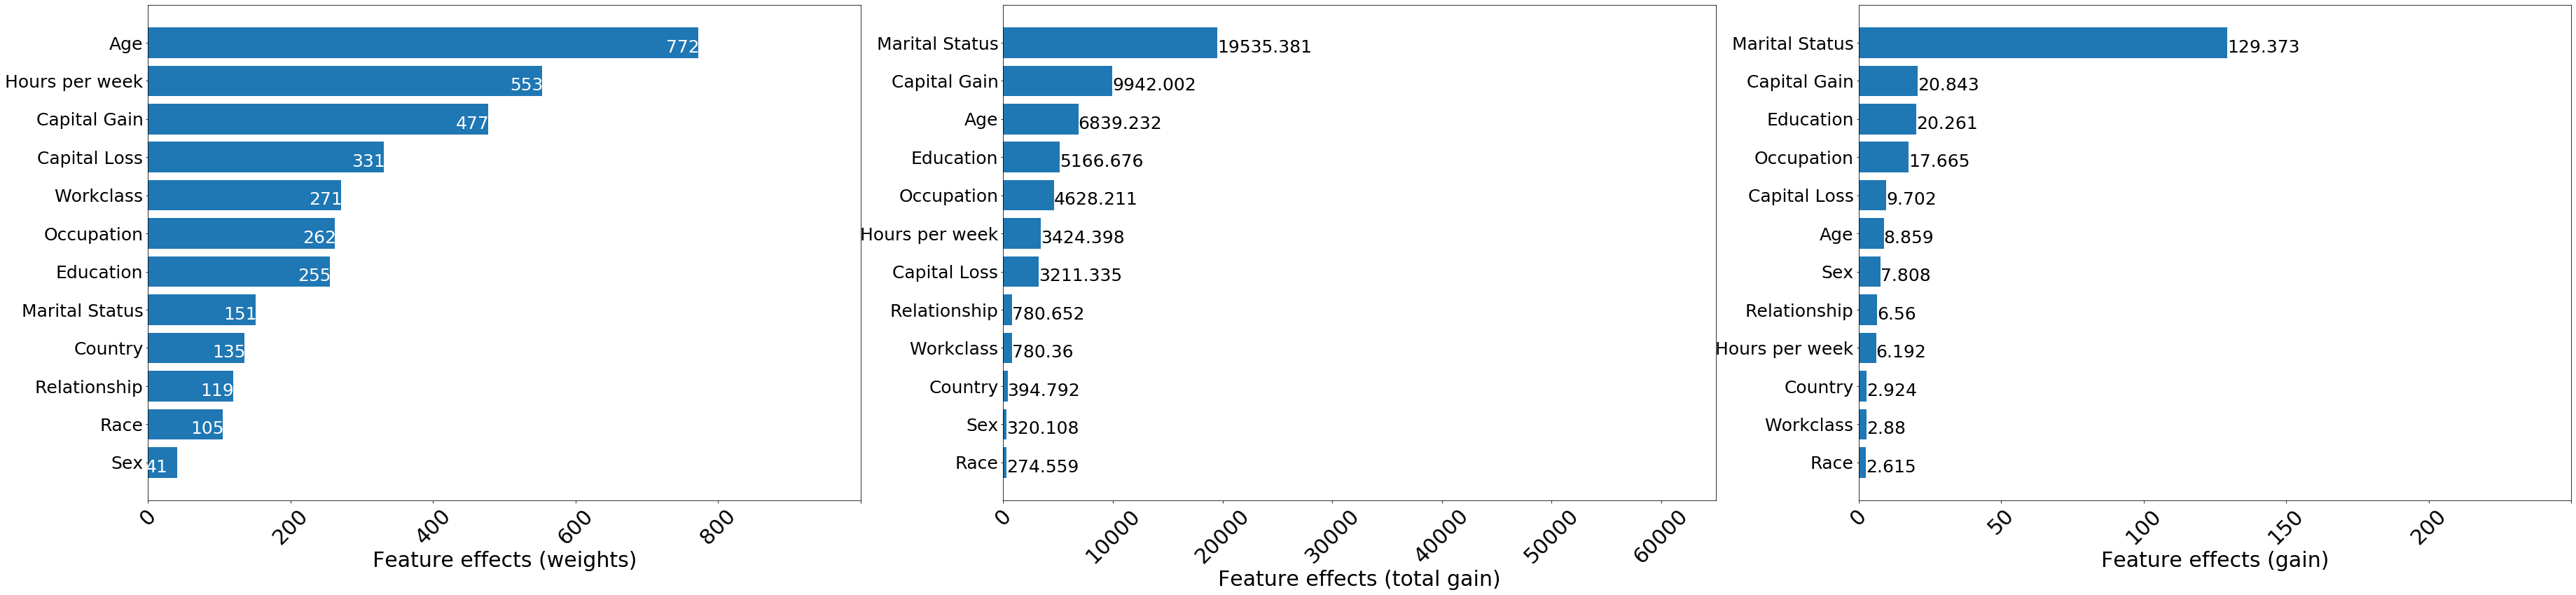

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(62, 13))
plot_importance(imp_by_weight_v, imp_by_weight_n, ax=ax1, xlabel='Feature effects (weights)', textxpos=45, right_x=1000, step=200 )
plot_importance(imp_by_gain_v, imp_by_gain_n, ax=ax2, xlabel='Feature effects (total gain)', textxpos=5, right_x=65000, step=10000, textcolor='black')
plot_importance(imp_by_a_gain_v, imp_by_a_gain_n, ax=ax3, xlabel='Feature effects (gain)', textxpos=0, right_x=250, step=50, textcolor='black')

Figure 2: Feature importances as measured by the total number of splits (left), total loss decrease due to feature (middle) and  average decrease in loss due to splitting on a particular feature (right)


When using the `weight` criterion for feature importance, all the continuous variables are ranked above categorical ones in terms of feature importance. This occurs because these continuous variables can be split multiple times at different levels in the tree, whereas binary variables  such as `Sex` can only be used to partition the data once, so the expected number of splits is smaller for such a variable. To avoid such biases, the feature importance  can be quantified by using the total and average gain in information (or, equivalently, decrease in objective). Although the `Marital Status` feature was used to partition the data only 151 times, it contributed the most to decreasing the loss, both across the entire ensemble and when averaged across the splits.

In general, the notion of importance should balance the information gain from making a split on a particular feature with how frequently this feature is used for splitting. Features such as `Age` may have a large cumulative gain courtesy to them being split on multiple times, but on average they may contribute less to the outcome compared to other features such as `Capital Gain` which are also split on significant number of times.

However, despite mitigating some of the shortcomings of the split-frequency feature importance, the gain notion of feature-importance suffers from *lack of consistency*, a property that allows one to compare feature effects across models. The interested reader is referred to [this](https://static-content.springer.com/esm/art%3A10.1038%2Fs42256-019-0138-9/MediaObjects/42256_2019_138_MOESM1_ESM.pdf) example (page 22) published by Lundberg et al. for details. Such a problem can be mitigated by defining the notion of feature importance with respect to Shapley values, which are consistent as well as faithful to the model (locally).

## Explaining xgboost with path-dependent Tree SHAP: global knowledge from local explanations

As described in the [overview](https://docs.seldon.io/projects/alibi/en/stable/methods/TreeSHAP.html), the path-dependent feature perturbation Tree SHAP algorithm uses node-level statistics (cover) extacted from the training data in order to estimate the effect of missing features on the model output. Since tree structures also support efficient computation of the model outputs for all possible subsets of missing features, the use of tree paths makes exact shap value estimation possible _without_ a background dataset. In contrast, algorithms such as Kernel SHAP use a background dataset to _approximate_ shap values while interventional feature perturbation Tree SHAP uses a background dataset to compute the effect of missing features on function output and _exactly_ computes the feature contributions given these values.  

In [18]:
path_dependent_explainer = TreeShap(model, model_output='raw', task='classification')
path_dependent_explainer.fit() # does not require background_data

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Predictor returned a scalar value. Ensure the output represents a probability or decision score as opposed to a classification label!


TreeShap(meta={
    'name': 'TreeShap',
    'type': ['whitebox'],
    'task': 'classification',
    'explanations': ['local', 'global'],
    'params': {'summarise_background': False, 'kwargs': {}}
})

Note that the `model_output` kwarg was set to `raw`, to indicate the fact that the model outputs log-odds ratios<sup>[(2)](#Footnotes) </sup>. This is the only option supported at this moment by this algorithm.
<a id='f_4'></a>


In [19]:
path_dependent_explanation = path_dependent_explainer.explain(X_test)
path_dependent_shap_values = path_dependent_explanation.shap_values[0]

The shap values computed in this way have the local accuracy property, as expected. That is, they sum to the difference between the model output to be explained and the reference value. 

In [20]:
np.max(np.abs(model.predict(dtest) - path_dependent_explainer.expected_value - path_dependent_shap_values.sum(1)))

0.5000074921901536

The features which are most important for the predicting whether an individual makes an income greater than \\$50, 000 are shown in Figure 3, where the feature importance of feature $j$ is defined as:

$$
I_j = \frac{1}{N}\sum \limits_{i=1}^N |\phi_{i,j}|.
$$

Here $N$ is the size of the explained dataset. According to this criterion, the `Marital Status` feature seems to be the most important, followed by features such as `Age` or `Capital Gain`. This global view does not provide information about the _direction_ of the effect at individual level (i.e., whether the prediction that an individual earns more than \$50, 000 is affected positively or negatively by a particular feature), the _magnitude_ of the effect at individual level (i.e., whether the `Marital Status` feature, the most important globally, has a significant impact on the prediction about each individual) or the _prevalence_ of a particular effect (how many members of the population are affected in similar ways by a particular feature).


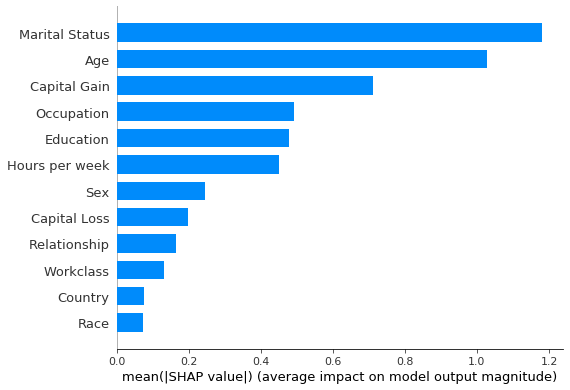

In [21]:
shap.summary_plot(path_dependent_shap_values, X_test, feature_names, plot_type='bar')

Figure 3: Most important features as predicted by the path-dependent perturbation Tree SHAP algorithm
<a id='figure_3'></a>

To answer such questions, the same feature ranking can be displayed in a _summary plot_ (Figure 4), which is an aggregation of local explanations. Note that at each feature, points with the same shap value pile up to show density.

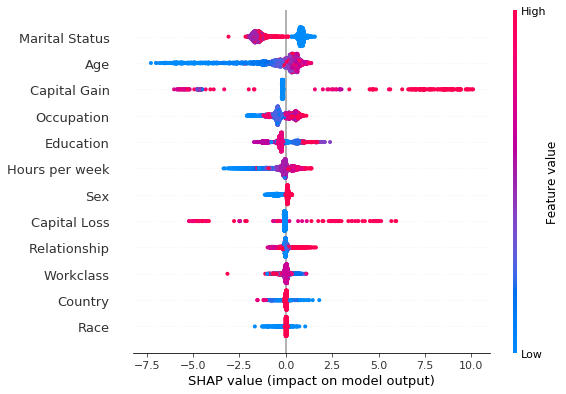

In [22]:
shap.summary_plot(path_dependent_shap_values, X_test, feature_names, class_names=target_names)

Figure 4: Summary plot of the path-dependent perturbation Tree SHAP explanations for the test set 
<a id='figure_4'></a>

In [23]:
from collections import Counter

feat_name = 'Marital Status'
decode_dict = {}
for i, val in enumerate(category_map[feature_names.index(feat_name)]):
    decode_dict[i] = val
print("Mapping of feature encoded values to readable values", decode_dict)

Mapping of feature encoded values to readable values {0: 'Married', 1: 'Never-Married', 2: 'Separated', 3: 'Widowed'}


The summary plot shows that being married increases the odds of making more than \$50, 000 and that, with few exceptions, being widowed decreases the odds of making an income above this threshold. Despite having a significant effect in aggregate, the `Age` feature does not affect all individuals as significantly: the impact on the prediction of this feature can be significantly negative for young individuals, making it unlikely that young individuals will be predicted to earn more than \$50, 0000. However, while in general elderly tend to be more wealthy, the impact of this feature can be less significant compared to other "less important" features such as `Capital Loss`, `Capital Gain` or `Education`. 

The tails in the summary plot of the `Capital Loss` feature indicate that while this feature is less important than `Education` or `Sex` as far as the global model behaviour is concerned, for specific individuals this feature can be a stronger predictor of the income class than the aforementioned features. This granularity in explanations is beyond the reach of traditional methods for tree interpretability.  

The vertical spread in the summary plots is indicative of feature interactions, which can be identified approximately, as described in this example, through the `shap` dependence plot. The [Model explanations with Shapley interaction values](#interactions) section shows that Tree SHAP supports exact computation of *Shapley interaction values* which allow attributing a change in an outcome not only to the features, but also to first order interactions between features. 

In [24]:
def _dependence_plot(features, shap_values, dataset, feature_names, category_map, display_features=None, **kwargs):
    """ 
    Plots dependence plots of specified features in a grid.
    
    features: List[str], List[Tuple[str, str]]
        Names of features to be plotted. If List[str], then shap 
        values are plotted as a function of feature value, coloured 
        by the value of the feature determined to have the strongest
        interaction (empirically). If List[Tuple[str, str]], shap
        interaction values are plotted.
    display_features: np.ndarray, N x F
        Same as dataset, but contains human readable values
        for categorical levels as opposed to numerical values
    """
    
    def _set_fonts(fig, ax, fonts=None, set_cbar=False):
        """
        Sets fonts for axis labels and colobar.
        """

        ax.xaxis.label.set_size(xlabelfontsize)
        ax.yaxis.label.set_size(ylabelfontsize)
        ax.tick_params(axis='x', labelsize=xtickfontsize)
        ax.tick_params(axis='y', labelsize=ytickfontsize)
        if set_cbar:
            fig.axes[-1].tick_params(labelsize=cbartickfontsize)
            fig.axes[-1].tick_params(labelrotation=cbartickrotation)
            fig.axes[-1].yaxis.label.set_size(cbarlabelfontsize)

    # parse plotting args
    figsize = kwargs.get("figsize", (15, 10))
    nrows = kwargs.get('nrows', len(features))
    ncols = kwargs.get('ncols', 1)
    xlabelfontsize = kwargs.get('xlabelfontsize', 14)
    xtickfontsize = kwargs.get('xtickfontsize', 11)
    ylabelfontsize = kwargs.get('ylabelfontsize', 14)
    ytickfontsize = kwargs.get('ytickfontsize', 11)
    cbartickfontsize = kwargs.get('cbartickfontsize', 14)
    cbartickrotation = kwargs.get('cbartickrotation', 10)
    cbarlabelfontsize = kwargs.get('cbarlabelfontsize', 14)
    rotation_orig = kwargs.get('xticklabelrotation', 25)
    
    alpha = kwargs.get("alpha", 1)
    x_jitter_orig = kwargs.get("x_jitter", 0.8)
    grouped_features = list(zip_longest(*[iter(features)] * ncols))
    
    
    fig, axes = plt.subplots(nrows, ncols,  figsize=figsize)
    if nrows == len(features):
        axes = list(zip_longest(*[iter(axes)] * 1))


    for i, (row, group) in enumerate(zip(axes, grouped_features), start=1):
        # plot each feature or interaction in a subplot
        for ax, feature in zip(row, group):
            # set x-axis ticks and labels and x-jitter for categorical variables
            if not feature:
                continue
            if isinstance(feature, list) or isinstance(feature, tuple):
                feature_index = feature_names.index(feature[0])
            else:
                feature_index = feature_names.index(feature)
            if feature_index in category_map:
                ax.set_xticks(np.arange(len(category_map[feature_index])))
                if i == nrows:
                    rotation = 90
                else:
                    rotation = rotation_orig
                ax.set_xticklabels(category_map[feature_index], rotation=rotation, fontsize=22)
                x_jitter = x_jitter_orig
            else:
                x_jitter = 0
            
            shap.dependence_plot(feature, 
                                 shap_values,
                                 dataset,
                                 feature_names=feature_names,
                                 display_features=display_features,
                                 interaction_index='auto',
                                 ax=ax,
                                 show=False,
                                 x_jitter=x_jitter,
                                 alpha=alpha
                                )
            if i!= nrows:
                ax.tick_params('x', labelrotation=rotation_orig)
            _set_fonts(fig, ax, set_cbar=True)
    
plot_dependence = partial(
    _dependence_plot, 
    feature_names=feature_names,
    category_map=category_map,
)

The dependence plots (Figure 5, below) reveal that the strongest interaction of the `Marital Status` shap values are due to the `Hours per week` variable. Although the odds for earning in excess of \$50, 000 are against people who are not married or have separated, they tend to be more favourable for individuals working long hours.

As far as `Age` is concerned, the odds of earning more increase as a person ages, and, in general, this variable is used by the model to assign individuals to a lower income class. People in their 30s-60s are thought to be more likely to make an income over \$50, 000 if their capital gains are high. Interestingly, for people over 60, high capital gains have a large negative contribution to the odds of making large incomes, a pattern that is perhaps not intuitive. 

As far as the `Hours per week` is concerned, one sees that older people working no to few hours a week are predicted better odds for making a larger income, and that, up to a certain threshold (of approximately 60 hours), working more than 20 hours increases the odds of a  > \$50, 000 prediction for all ages.

Finally, note that not knowing the occupation hurts the odds of predicting a high income. No significant interactions between the sex of the individual (males in red), their occupation and their predicted odds are observed with the exception of, perhaps, `Admin` and `Blue Collar` groups. 

<div class="alert alert-warning">
Warning
    
For the following plots to run the `matplotlib` version needs to be `<3.5.0`. This is because of an upstream issue of how the `shap.dependence_plot` function is handled in the `shap` library. An issue tracking it can be found [here](https://github.com/slundberg/shap/issues/2273).

</div>

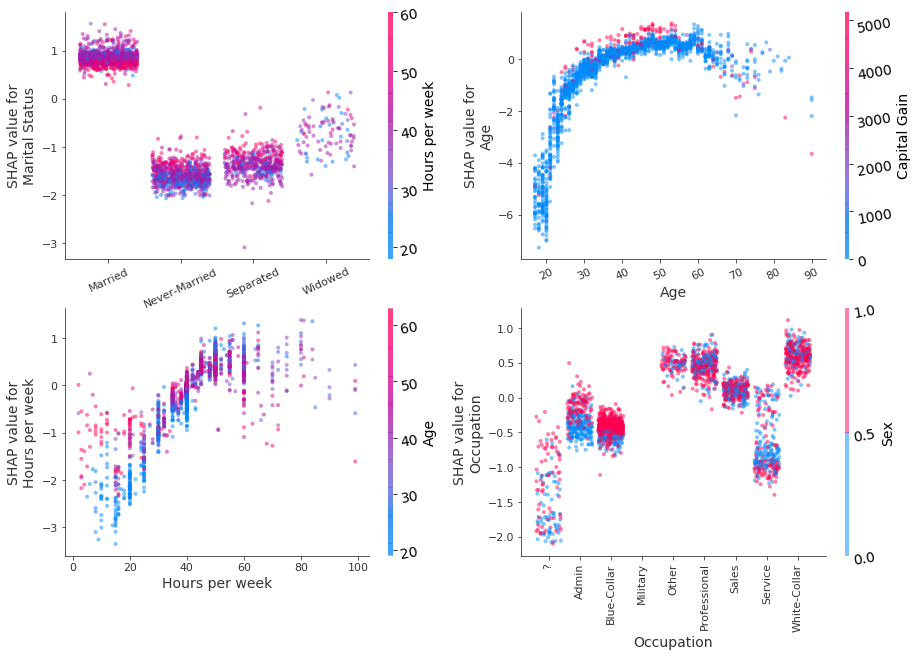

In [25]:
plot_dependence(
    ['Marital Status', 'Age', 'Hours per week', 'Occupation'], 
    path_dependent_shap_values, 
    X_test,  
    alpha=0.5, 
    x_jitter=0.8,
    nrows=2,
    ncols=2,
)

Figure 5: Decision plot of `Marital Status`, `Age`, `Hours per week`, `Occupation` features using the path-dependent perturbation Tree SHAP algorithm. Colouring is according to the value of the variable estimated to have the strongest interaction with the plotted variable. Jitter in the x direction has been applied to categorical variables to improve readability.
<a id='figure_5'></a>

Performing local explanations across multiple instances efficiently can provide insight into how features contributed to misclassifications and the most common causes of misclassification. This can be achieved by performing a similar analysis for those individuals whose income was predicted below \$50, 000 but who are known to make an income in excess of this threshold.

In [26]:
# identify false negatives
misclassified = (np.logical_and(y_test == 1, y_pred_test == 0)).nonzero()[0]
X_misclassified = X_test[misclassified]
# explain the predictions
shap_vals_misclassified = path_dependent_shap_values[misclassified, :]

The summary plot indicates that the feature with the most impact on misclassification is `Marital Status` and that the model does not correctly capture the fact that individuals who were never married, widowed or separated can also make high incomes.

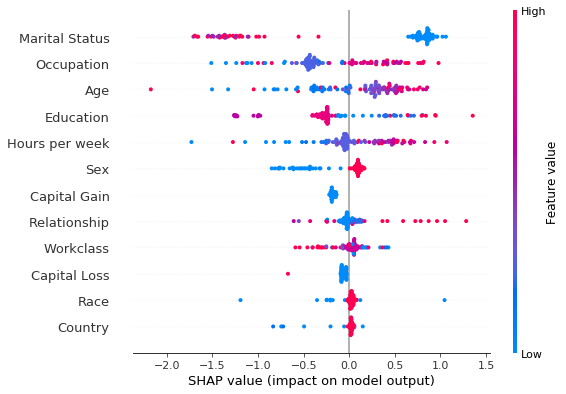

In [27]:
shap.summary_plot(shap_vals_misclassified, X_misclassified, feature_names )

Figure 6: Summary plot of path-dependent perturbation Tree SHAP explanations for individuals misclassified as earning less than \$50, 000. 
<a id='figure_6'></a>

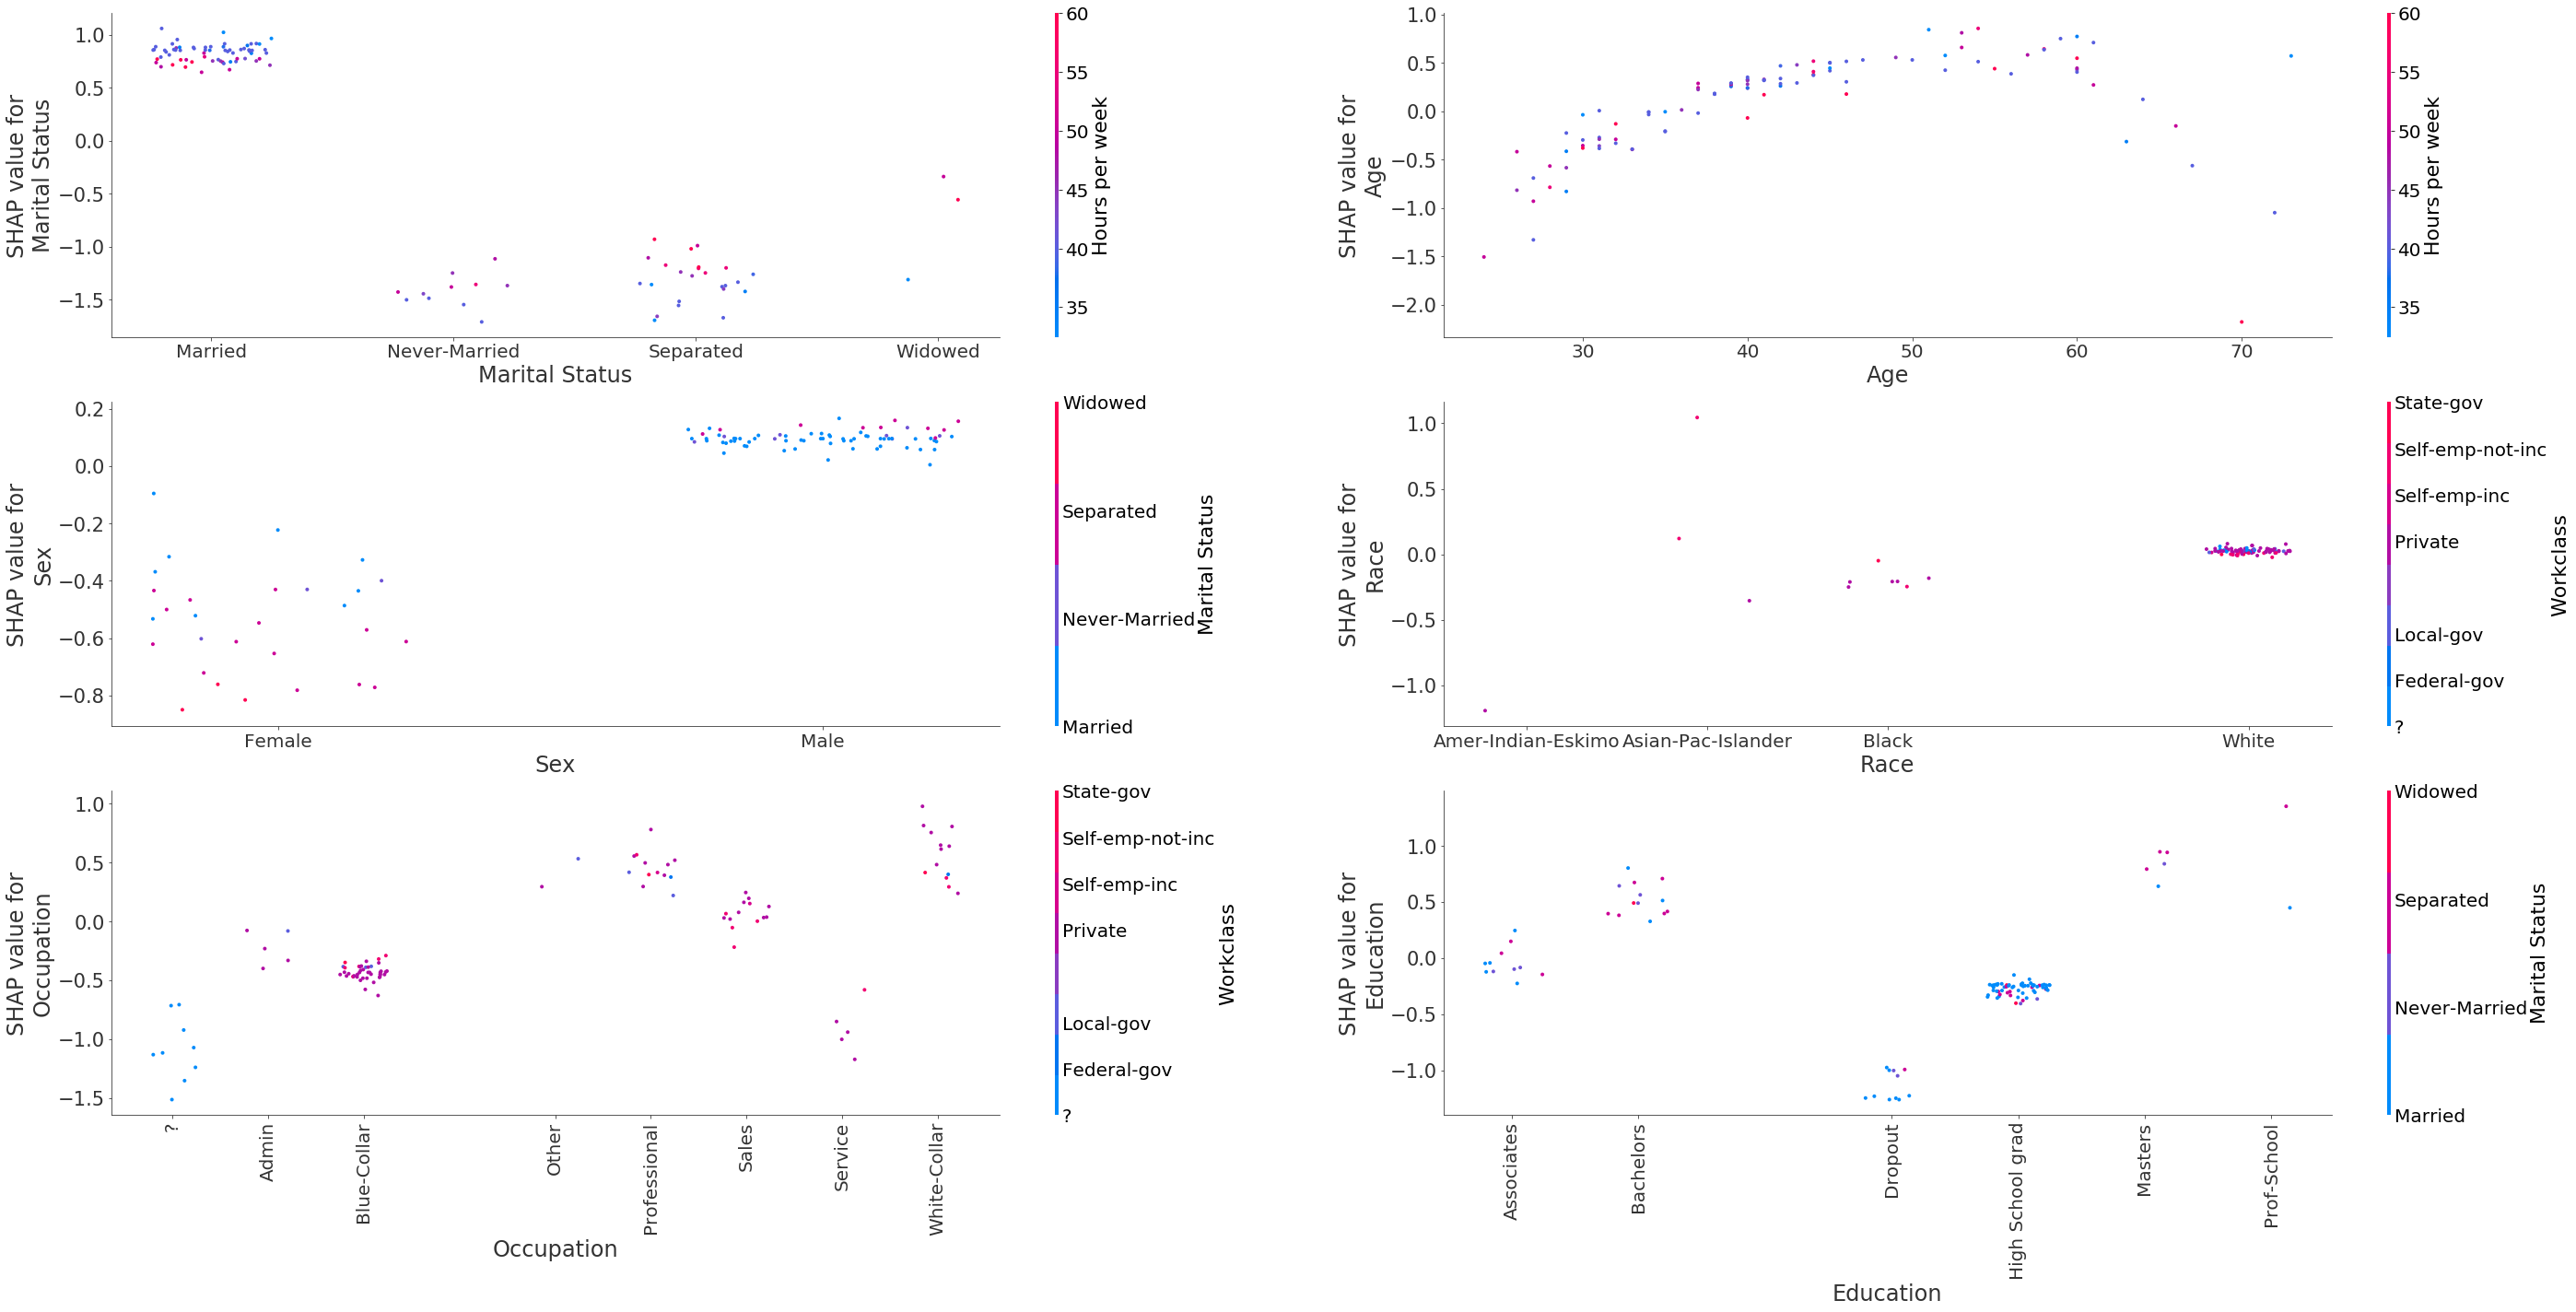

In [28]:
X_misclassified_display = decode_data(X_misclassified)
plot_dependence(
    ['Marital Status', 'Age',  'Sex', 'Race', 'Occupation', 'Education'], 
    shap_vals_misclassified, 
    X_misclassified, 
    display_features=X_misclassified_display, 
    rotation=33,
    figsize=(47.5, 22), 
    alpha=1, 
    x_jitter=0.5,
    nrows=3,
    ncols=2,
    xlabelfontsize=24,
    xtickfontsize=20,
    xticklabelrotation=0,
    ylabelfontsize=24,
    ytickfontsize=21,
    cbarlabelfontsize=22,
    cbartickfontsize=20,
    cbartickrotation=0,
    
)

Figure 7: Decision plots of the variables `Marital Status`, `Age`,  `Sex`, `Race`, `Occupation`, `Education` using the path-dependent Tree SHAP algorithm for individuals misclassified as earning less than \$50, 000. 
<a id='figure_7'></a>


Analysing the plots above reveals that some of the patterns that can lead to misclassification are:

- individuals are not married or are divorced/widowed

- individuals below 40 years old are expected to earn less, across all occupation categories 

- individuals are female; being single further increases the odds against the high income class

- racial bias does not seem to be one of the drivers of misclassification, although we can see that for `Black` people the contribution is slightly negative whereas for white people the contribution is zero 

- individuals being `Blue-Collar` workers, working in `Admin` jobs, the `Service` industry or individuals whose occupation is unknown 

- individuals having dropped out of education or being high school graduates

### Model explanations with Shapley interaction values
<a id='interactions'></a>

As described in the algorithm [overview](https://docs.seldon.io/projects/alibi/en/stable/methods/TreeSHAP.html), path-dependent feature perturbation Tree Shap can attribute a change in outcome not only to the $M$ input features, but to the $M$ features and the first-order interactions between them. For each instance to be explained, a tensor of $M \times M$ numbers is returned. The diagonal of this tensor, indexed by $(i, i)$, represents the _main effects_ (i.e., due to the feature itself) whereas the off-diagonal terms indexed by $(i, j)$ represent the _interaction between the $i$th and the $j$th feature in the input_. Summing along the rows of an entry in the Shapley interaction values tensor yields the $M$ shap values for that instance. Note that the interaction value is split equally between each feature so the returned matrix is symmetric;   the total interaction effect between feature $i$ and $j$ is therefore obtained by adding the two symmetric entries $(i,j)$ and $(j, i)$.

In [29]:
shap_interactions_explanation = path_dependent_explainer.explain(X_test, interactions=True)

In [30]:
shap_interactions_values = shap_interactions_explanation.shap_interaction_values[0]

Plots of the interactions between the features `Age`, `Sex`, `Education` and `Occupation` with `Capital Gain` are shown below.

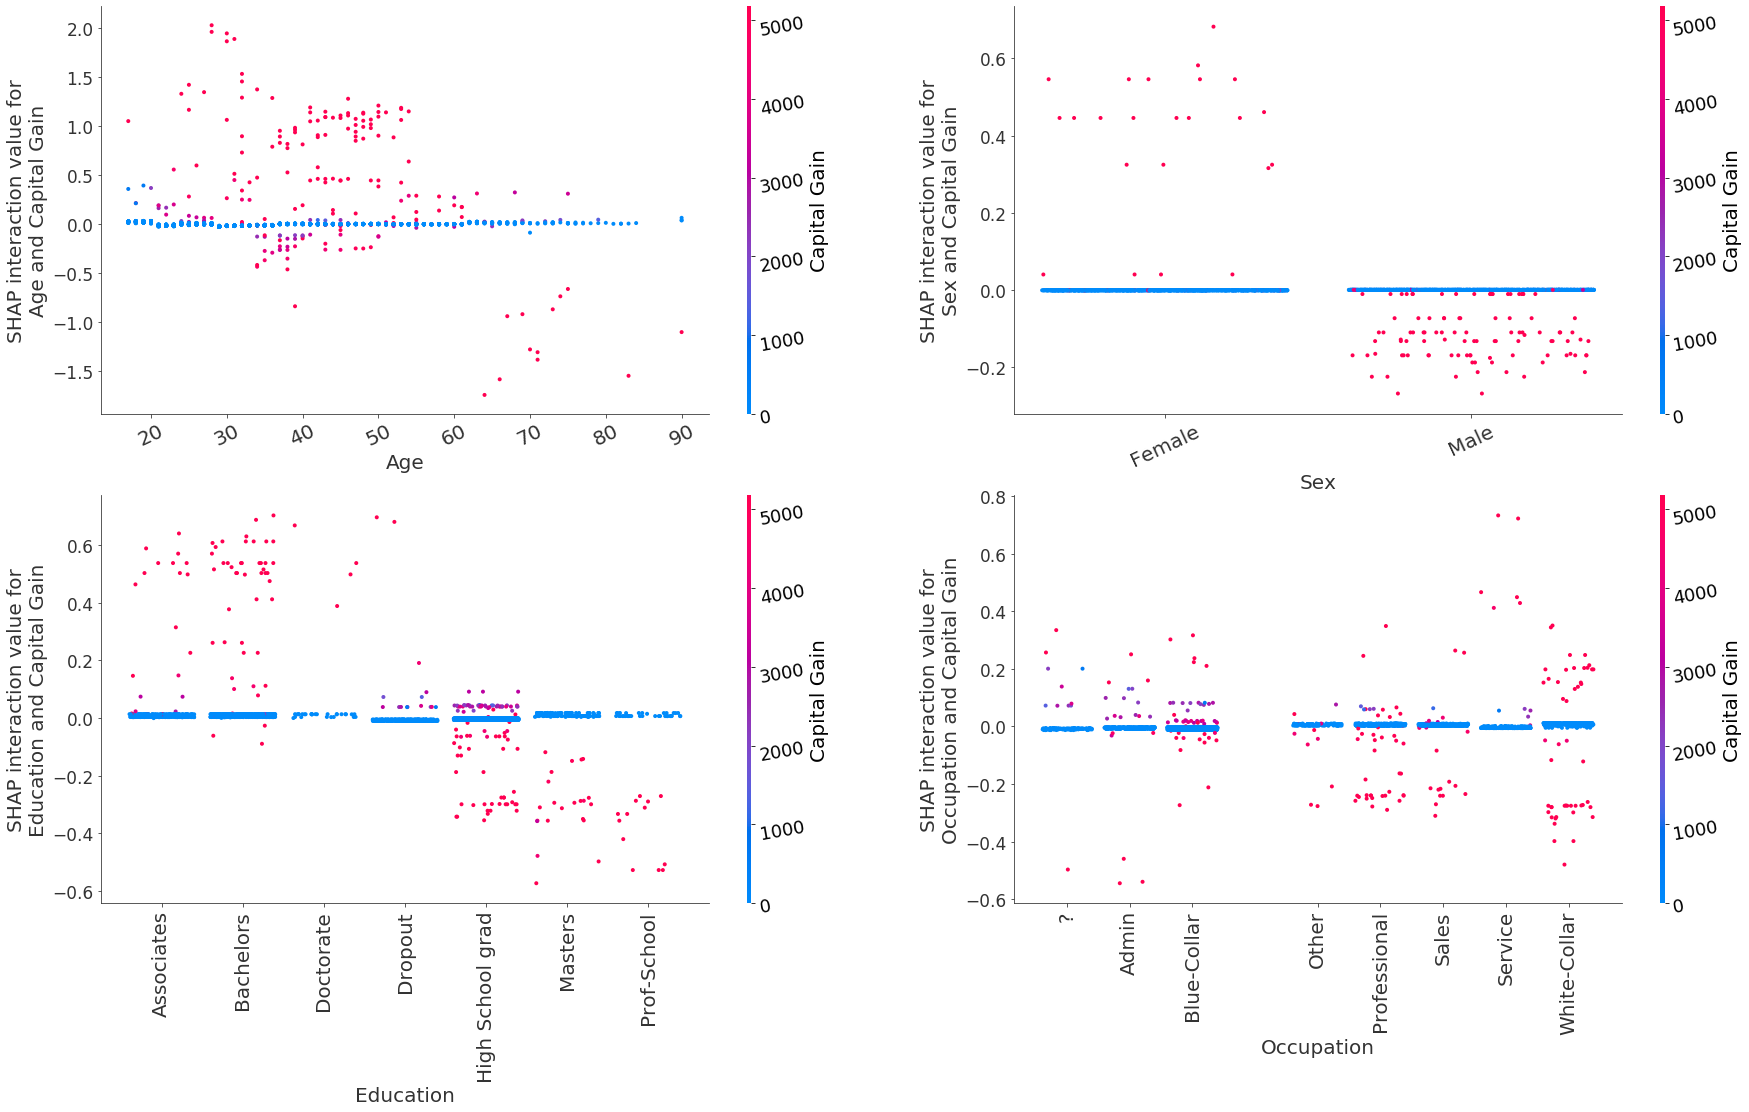

In [31]:
plot_dependence(
    [('Age', 'Capital Gain'),
    ('Sex', 'Capital Gain'), 
    ('Education', 'Capital Gain'), 
    ('Occupation', 'Capital Gain'), 
    ], 
    shap_interactions_values, 
    X_test, 
    figsize=(30,16.5), 
    rotation=15, 
    ncols=2, 
    nrows=2,
    display_features=X_display,
    xtickfontsize=20,
    xlabelfontsize=20,
    ylabelfontsize=20,
    ytickfontsize=17,
    cbarlabelfontsize=20,
    cbartickfontsize=18,
)

Figure 11: Shap interaction values for the features `Age`, `Sex`, `Education` and `Occupation` with `Capital Gain`
<a id='figure_11'></a>


The model has captured the following patterns:

- The interaction between `Age` and `Capital` gain increases the odds of predicting an income >\$50, 000 for most individuals below 60 years old but significantly decreases the odds for individuals above 60 years old. This interaction has no effect when the individuals don't have any capital gains

- For females, capital gains generally increase the prediction odds while for males they decrease them, although these latter interactions are much smaller in magnitude

- Having a capital gain and education level at `Masters` and `Prof-School` or `High School grad` decreases the prediction odds for higher income

- For most individuals in occupation categories `Professional` and `Sales`, high capital gains slightly reduce the odds of predicting >\$50, 000. For `White-Collar` individuals, high capital gain can both increase or decrease the odds.

The `plot_decomposition` function can be used to decompose the shap values of a particular feature into a set of shap values that do not account for the interaction with a specific feature and the interaction values with that specific feature, as shown below. This is depicted in Figure 12.

In [32]:
def plot_decomposition(feature_pair, shap_interaction_vals, features, feat_names, display_features=None, **kwargs):
    """
    Given a list containing two feature names (`feature_pair`), an n_instances x n_features x n_features tensor 
    of shap interaction values (`shap_interaction_vals`), an n_instances x n_features (`features`) tensor of 
    feature values and a list of feature names (which assigns a name to each column of `features`), this function 
    plots:
        - left: shap values for feature_pair[0] coloured by the value of feature_pair[1]
        - middle: shap values for feature_pair[0] after subtracting the interaction with feature_pair[1]
        - right: the interaction values between feature_pair[0] and feature_pair[1], which are subtracted 
        from the left plot to get the middle plot
        
    NB: `display_features` is the same shape as `features` but should contain the raw categories for categorical 
    variables so that the colorbar can be discretised and the category names displayed alongside the colorbar.
    """
    
    def _set_fonts(fig, ax, fonts=None, set_cbar=False):
        """
        Sets fonts for axis labels and colobar.
        """

        ax.xaxis.label.set_size(xlabelfontsize)
        ax.yaxis.label.set_size(ylabelfontsize)
        ax.tick_params(axis='x', labelsize=xtickfontsize)
        ax.tick_params(axis='y', labelsize=ytickfontsize)
        if set_cbar:
            fig.axes[-1].tick_params(labelsize=cbartickfontsize)
            fig.axes[-1].yaxis.label.set_size(cbarlabelfontsize)

    # parse plotting args
    xlabelfontsize = kwargs.get('xlabelfontsize', 21)
    ylabelfontsize = kwargs.get('ylabelfontsize', 21)
    cbartickfontsize = kwargs.get('cbartickfontsize', 16)
    cbarlabelfontsize = kwargs.get('cbarlabelfontsize', 21)
    xtickfontsize = kwargs.get('xtickfontsize', 20)
    ytickfontsize = kwargs.get('ytickfontsize', 20)
    alpha = kwargs.get('alpha', 0.7)
    figsize = kwargs.get('figsize', (44, 10))
    ncols = kwargs.get('ncols', 3)
    nrows = kwargs.get('nrows', 1)
    # compute shap values and shap values without interaction
    feat1_idx = feat_names.index(feature_pair[0])
    feat2_idx = feat_names.index(feature_pair[1])
    # shap values
    shap_vals = shap_interaction_vals.sum(axis=2)
    # shap values for feat1, all samples
    shap_val_ind1 = shap_interaction_vals[..., feat1_idx].sum(axis=1)
    # shap values for (feat1, feat2) interaction 
    shap_int_ind1_ind2 = shap_interaction_vals[:, feat2_idx, feat1_idx]
    # subtract effect of feat2
    shap_val_minus_ind2 = shap_val_ind1 - shap_int_ind1_ind2
    shap_val_minus_ind2 = shap_val_minus_ind2[:, None]

    # create plot

    fig, (ax1, ax2, ax3) = plt.subplots(nrows, ncols, figsize=figsize)

    # plot the shap values including the interaction
    shap.dependence_plot(feature_pair[0],
                         shap_vals,
                         features,
                         display_features = display_features,
                         feature_names=feat_names,
                         interaction_index=feature_pair[1],
                         alpha=alpha,
                         ax=ax1,
                         show=False)
    _set_fonts(fig, ax1, set_cbar=True)

    # plot the shap values excluding the interaction
    shap.dependence_plot(0,
                         shap_val_minus_ind2,
                         features[:, feat1_idx][:, None],
                         feature_names=[feature_pair[0]],
                         interaction_index=None,
                         alpha=alpha,
                         ax=ax2,
                         show=False,
                         )
    ax2.set_ylabel(f' Shap value for  {feature_pair[0]} \n wo {feature_pair[1]} interaction')
    _set_fonts(fig, ax2)
    
    # plot the interaction value
    shap.dependence_plot(feature_pair,
                         shap_interaction_vals,
                         features,
                         feature_names=feat_names,
                         display_features=display_features,
                         interaction_index='auto',
                         alpha=alpha,
                         ax=ax3,
                         show=False,
                        )
    _set_fonts(fig, ax3, set_cbar=True)
    

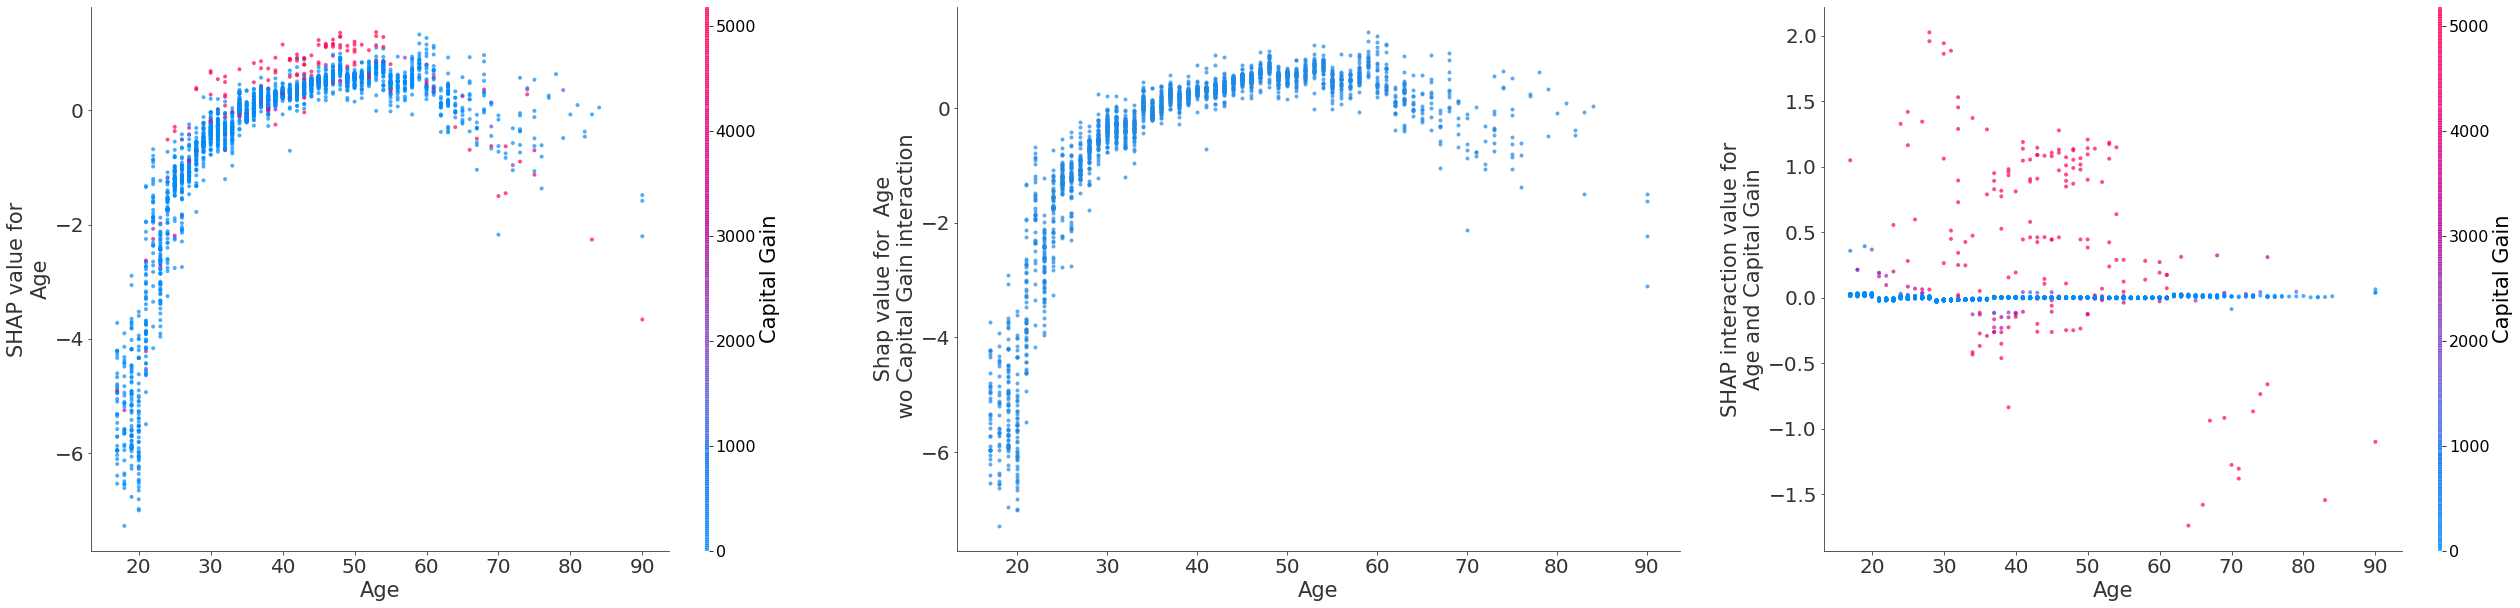

In [33]:
feature_pair = ('Age', 'Capital Gain')
plot_decomposition(
    feature_pair, 
    shap_interactions_values, 
    X_test, 
    feature_names, 
    display_features=X_display,
)

Figure 12: A decomposition of the shap values for `Age` (left) into shap values for `Age` excluding the `Capital Gain` interaction (middle). The total interaction between `Age` and `Capital Gain` shown on right.

## Model explanations using xgboost `predict` method

The `xgboost` library implements an optimised version of the path-dependendent feature perturbation algorithm, which is also internally used by the `shap` library. `xgboost` also provides an optimised algorithm for computing the shap interaction values.

The `predict` method can output the shap values if called as follows: 

In [34]:
xgb_shap_vals = model.predict(dtest, pred_contribs=True)

In [35]:
print(f"shap values shape: {xgb_shap_vals.shape}")

shap values shape: (2560, 13)


Note that there are only 12 features in the dataset. The last column is the expected value with respect to which the feature contributions are computed. 

One can also estimate the shap interaction values as follows:

In [36]:
xgb_shap_interaction_vals = model.predict(dtest, pred_interactions=True)

In [37]:
print(f"shap values shape: {xgb_shap_interaction_vals.shape}")

shap values shape: (2560, 13, 13)


Note that the expected value is again returned in the last column.

The `xgboost` library also implements an approximate feature attribution method, first described by Sabaas [here](https://github.com/andosa/treeinterpreter). This feature attribution method is similar in spirit to Shapley value, but does not account for the effect of variable order as explained [here](https://static-content.springer.com/esm/art%3A10.1038%2Fs42256-019-0138-9/MediaObjects/42256_2019_138_MOESM1_ESM.pdf) (pp. 10-11). This explanation method can be invoked as follows:

In [38]:
xgb_sabaas = model.predict(dtest, pred_contribs=True, approx_contribs=True)

## Footnotes

<a id='Footnotes'></a>


[(1)](#f_2): See the algorithm [overview](https://docs.seldon.io/projects/alibi/en/stable/methods/TreeSHAP.html) for a brief explanation of coverage. 

[(2)](#f_4): `model_output=raw` should always be used with the path-dependent perturbation for classification problems in `xgboost`, irrespective of whether the model is trained with the `binary:logitraw` or `binary:logistic`. Even though a model trained with the latter outputs probabilities, internally `xgboost` explains the output in margin space due to the `model_output=raw` option. To explain the probability output of a model, one should use the interventional algorithm and pass `model_output=probability` to the constructor along with the objective `binary:logistic` to the training function.  
